In [10]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################
import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [15, 10]
import json
import pandas as pd
import glob
import math
import ast
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('logs/full_1/*.json' )

print(len(LOGFILES),"logs")

#=== line colors and styles

linestyles = {
    #=======floorplans===============
    'office'              : 'dotted' ,
    'warehouse'           : 'dashed' ,
    'factory'             : 'dashdot',
    "scattered_obstacles" : 'dotted',
    #=======algorithms================
    #------exploration---------------- 
    'Atlas'      :    'solid',
    #----relay placement--------------
    'Recovery'   :    'dotted',
    'SelfHealing':    'dashed',
    'Naive'      :    'dashdot',
}

linecolors = {
    #=======floorplans==============
    'office'              : 'orange',
    'warehouse'           : 'green',
    'factory'             : 'purple',
    "scattered_obstacles" : 'blue',
    #=======algorithms==============
    #------exploration--------------
    'Atlas'      :  'royalblue',
    #------relay placement----------
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :     'orange',
     
   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

1200 logs


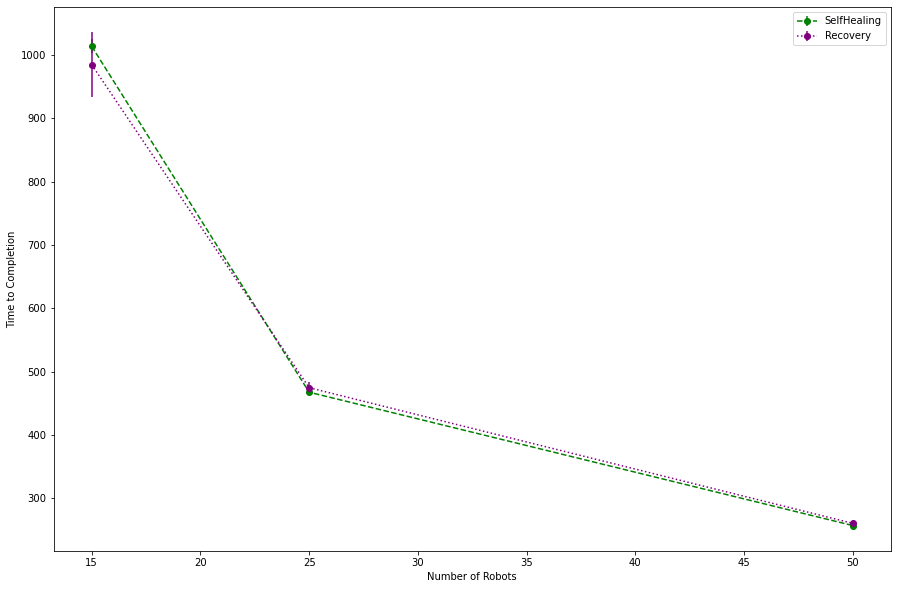

In [13]:

#============ Time To Completion
plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42
plt.rcParams['figure.figsize'] = [15, 10]

# format -> data = {seed1: {config: {....}}, timeToCompletion: 2142}, seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines  = [json.loads(l) for l in f]
    for line in lines:
        if line["type"] == "simSetting":
            numRobots             = line['simSetting']['numRobots'] 
            floorplan             = line['simSetting']['floorplan'] 
            relayAlgorithm        = line['simSetting']['relayAlgorithm']
            
        
        if line["type"] == "KPI":
            if line['timeToCompletion'] != None:
                timeToCompletion      = line['timeToCompletion']
                break
 
    data += [
        {"numRobots":       numRobots,
         "floorplan":       floorplan,
         "relayAlgorithm":  relayAlgorithm,
         "timeToComletion": timeToCompletion,
        }
    ]

floorplans      = list(set([d['floorplan'] for d in data]))
relayAlgorithms = list(set([d['relayAlgorithm'] for d in data]))
numRobots       = list(set([d['numRobots'] for d in data]))
numRobots.sort()

(fig,ax) = plt.subplots()
for floorplan in floorplans:
    for relayAlgorithm in relayAlgorithms:
        toPlot = {}
        for value in numRobots:
            toPlot[value] = {}
            (m, h) = mean_confidence_interval(
                [
                 d["timeToComletion"] for d in data    if 
                 d['numRobots']==value                 and 
                 d['floorplan'] == floorplan           and 
                 d['relayAlgorithm'] == relayAlgorithm
                ]
            )
            toPlot[value]["mean"] = m
            toPlot[value]["yerr"] = h
            x                     = numRobots
            y                     = [p["mean"] for p in toPlot.values()]
            yerr                  = [p["yerr"] for p in toPlot.values()]
        ax.errorbar(x, y, yerr=yerr,linestyle=linestyles[relayAlgorithm],color=linecolors[relayAlgorithm],label=relayAlgorithm, marker='o')

plt.xlabel("Number of Robots")
plt.ylabel("Time to Completion")
ax.legend()



In [ ]:
#============ Plot Time To Completion vs number of robots per Floorplan